In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque


In [2]:

# -------------------------
# Hyperparameters
# -------------------------
ENV_NAME = "Pendulum-v1"
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 64
MEMORY_SIZE = 10_000
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 500
TARGET_UPDATE = 50
NUM_EPISODES = 1000

device = torch.device("mps")
print(f"Using device: {device}")

Using device: mps


In [3]:
N_ACTIONS = 11
TORQUE_MAX = 2.0
ACTION_VALUES = np.linspace(-TORQUE_MAX, TORQUE_MAX, N_ACTIONS)

In [4]:

# -------------------------
# Replay buffer
# -------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32, device=device),
            torch.tensor(actions, dtype=torch.int64, device=device),
            torch.tensor(rewards, dtype=torch.float32, device=device),
            torch.tensor(next_states, dtype=torch.float32, device=device),
            torch.tensor(dones, dtype=torch.float32, device=device),
        )

    def __len__(self):
        return len(self.buffer)


In [5]:

# -------------------------
# Q-network
# -------------------------
class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
# -------------------------
# Epsilon schedule
# -------------------------
def epsilon_by_step(step):
    return EPS_END + (EPS_START - EPS_END) * np.exp(-step / EPS_DECAY)

# -------------------------
# Training setup
# -------------------------
env = gym.make(ENV_NAME)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]


policy_net = QNetwork(obs_dim, N_ACTIONS).to(device)
target_net = QNetwork(obs_dim, N_ACTIONS).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayBuffer(MEMORY_SIZE)

global_step = 0

In [7]:
print(env.unwrapped.__doc__)



    ## Description

    The inverted pendulum swingup problem is based on the classic problem in control theory.
    The system consists of a pendulum attached at one end to a fixed point, and the other end being free.
    The pendulum starts in a random position and the goal is to apply torque on the free end to swing it
    into an upright position, with its center of gravity right above the fixed point.

    The diagram below specifies the coordinate system used for the implementation of the pendulum's
    dynamic equations.

    ![Pendulum Coordinate System](/_static/diagrams/pendulum.png)

    - `x-y`: cartesian coordinates of the pendulum's end in meters.
    - `theta` : angle in radians.
    - `tau`: torque in `N m`. Defined as positive _counter-clockwise_.

    ## Action Space

    The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.

    | Num | Action | Min  | Max |
    |-----|--------|------|-----|
    | 0   | Torque | -2.

In [8]:
env.action_space

Box(-2.0, 2.0, (1,), float32)

In [9]:
episode_returns = []

for episode in range(NUM_EPISODES):
    state, _ = env.reset()
    episode_reward = 0

    while True:
        global_step += 1
        eps = epsilon_by_step(global_step)

        if random.random() < eps:
            action_idx = random.randrange(N_ACTIONS)
        else:
            with torch.no_grad():
                qvals = policy_net(
                    torch.tensor(state, dtype=torch.float32, device=device)
                )
                action_idx = qvals.argmax().item()

        action = np.array([ACTION_VALUES[action_idx]], dtype=np.float32)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        memory.push(state, action_idx, reward, next_state, done)


        state = next_state
        episode_reward += reward

        if len(memory) >= BATCH_SIZE:
            states, actions, rewards, next_states, dones = memory.sample(BATCH_SIZE)

            q_values = policy_net(states).gather(
                1, actions.unsqueeze(1)
            ).squeeze(1)

            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0]
                target_q = rewards + GAMMA * max_next_q * (1 - dones)

            loss = nn.functional.mse_loss(q_values, target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode:3d} | Reward: {episode_reward:7.2f}")
    episode_returns.append(episode_reward)

env.close()


/var/folders/x9/dh89t46x5_z5tc2g4ynx0kj40000gn/T/ipykernel_55368/1267706669.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  torch.tensor(states, dtype=torch.float32, device=device),


Episode   0 | Reward: -1320.60
Episode   1 | Reward: -878.61
Episode   2 | Reward: -1193.80
Episode   3 | Reward: -977.00
Episode   4 | Reward: -908.78
Episode   5 | Reward: -1591.83
Episode   6 | Reward: -1055.77
Episode   7 | Reward: -1086.94
Episode   8 | Reward: -762.45
Episode   9 | Reward: -1341.25
Episode  10 | Reward: -754.15
Episode  11 | Reward: -864.45
Episode  12 | Reward: -1008.77
Episode  13 | Reward: -1064.66
Episode  14 | Reward: -1132.74
Episode  15 | Reward: -1021.10
Episode  16 | Reward: -1371.83
Episode  17 | Reward: -1782.00
Episode  18 | Reward: -1035.23
Episode  19 | Reward: -1022.05
Episode  20 | Reward: -950.07
Episode  21 | Reward: -797.37
Episode  22 | Reward: -759.31
Episode  23 | Reward: -1682.35
Episode  24 | Reward: -1349.21
Episode  25 | Reward: -1462.15
Episode  26 | Reward: -1510.84
Episode  27 | Reward: -1292.27
Episode  28 | Reward: -1071.70
Episode  29 | Reward: -1010.54
Episode  30 | Reward: -1096.87
Episode  31 | Reward: -1205.11
Episode  32 | Rew

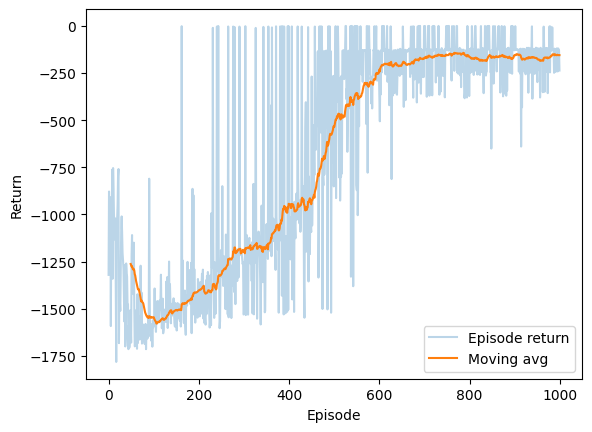

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(episode_returns, alpha=0.3, label="Episode return")

# Moving average
window = 50
ma = np.convolve(
    episode_returns,
    np.ones(window)/window,
    mode="valid"
)
plt.plot(range(window-1, len(episode_returns)), ma, label="Moving avg")

plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()


In [16]:
env = gym.make("Pendulum-v1", render_mode="human")
state_vars = []
state, _ = env.reset()
done = False

while not done:
    with torch.no_grad():
        state_tensor = torch.tensor(
            state, dtype=torch.float32, device=device
        )
        action_idx = policy_net(state_tensor).argmax().item()
        action = np.array([ACTION_VALUES[action_idx]], dtype=np.float32)

    state, reward, terminated, truncated, _ = env.step(action)
    state_vars.append(state)
    done = terminated or truncated
    print(f"Reward: {reward:.2f}")

env.close()


Reward: -1.47
Reward: -1.75
Reward: -2.34
Reward: -3.24
Reward: -4.49
Reward: -5.93
Reward: -7.66
Reward: -9.98
Reward: -12.57
Reward: -14.69
Reward: -12.90
Reward: -10.92
Reward: -8.95
Reward: -6.93
Reward: -5.09
Reward: -3.75
Reward: -2.50
Reward: -1.80
Reward: -1.30
Reward: -0.78
Reward: -0.67
Reward: -0.38
Reward: -0.20
Reward: -0.10
Reward: -0.12
Reward: -0.05
Reward: -0.07
Reward: -0.03
Reward: -0.05
Reward: -0.02
Reward: -0.01
Reward: -0.03
Reward: -0.01
Reward: -0.01
Reward: -0.02
Reward: -0.01
Reward: -0.01
Reward: -0.02
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.02
Reward: -0.01
Reward: -0.01
Reward: -0.02
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.02
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.02
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.02
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.01
Reward: -0.02
Reward: -0.01
Reward: -0.02
Reward: -0.02
Reward: -0.01
Reward: -0.01
Reward: -0.02
Re

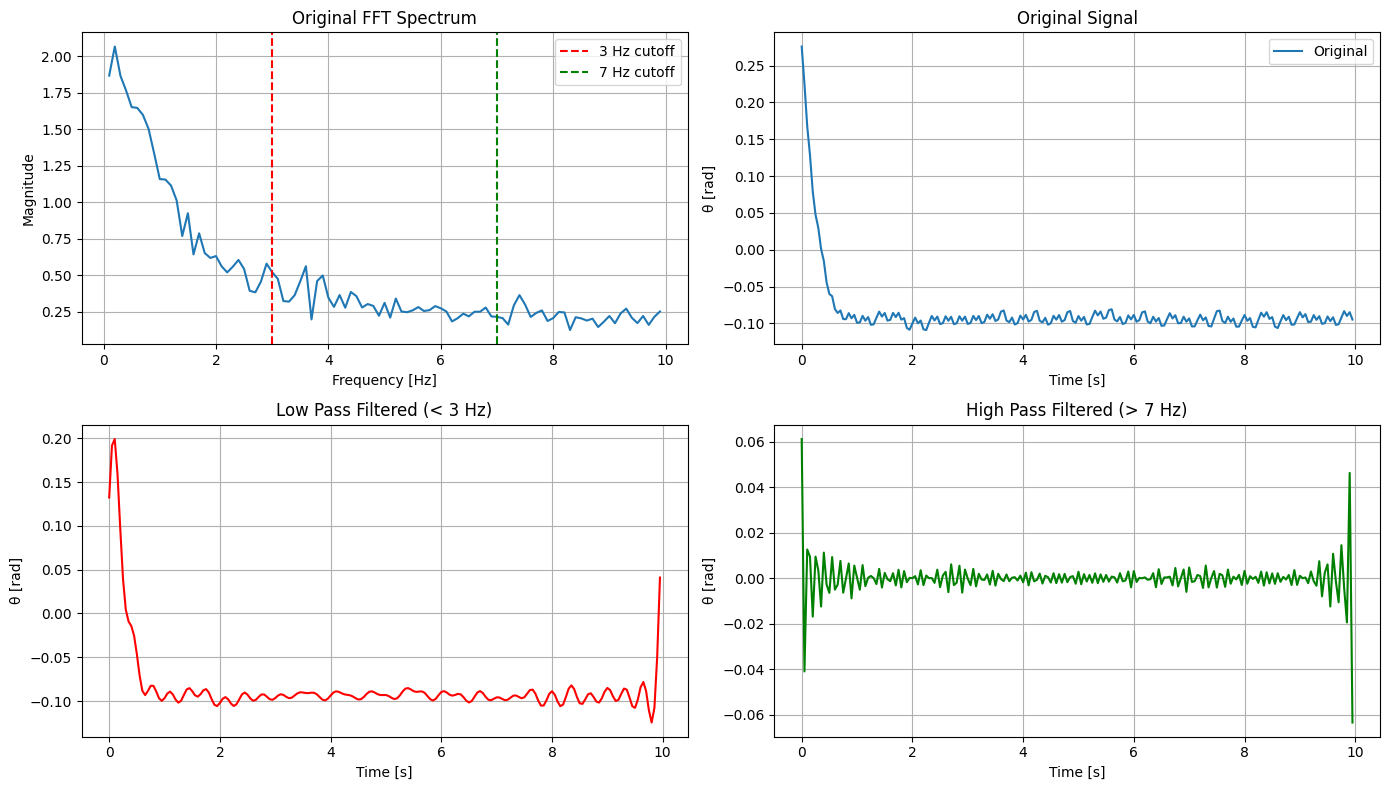

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Convert collected states to array
state_vars = np.array(state_vars)

# Extract variables
cos_theta = state_vars[:, 0] # x-coordinate
sin_theta = state_vars[:, 1] # y-coordinate
theta_dot = state_vars[:, 2]

# Recover angle theta
theta = np.arctan2(sin_theta, cos_theta)

# Sampling parameters
dt = env.unwrapped.dt          # Pendulum timestep (0.05 s)
N = len(theta)

# FFT
theta_fft = np.fft.fft(theta)
theta_dot_fft = np.fft.fft(theta_dot)
freqs = np.fft.fftfreq(N, d=dt)

# Apply low pass filter at 3 Hz
theta_fft_lowpass = theta_fft.copy()
theta_fft_lowpass[np.abs(freqs) > 3] = 0
theta_lowpass = np.fft.ifft(theta_fft_lowpass).real

# Apply high pass filter at 7 Hz
theta_fft_highpass = theta_fft.copy()
theta_fft_highpass[np.abs(freqs) < 7] = 0
theta_highpass = np.fft.ifft(theta_fft_highpass).real

# Use only positive frequencies for plotting
mask = freqs > 0

# Plot FFT magnitude and filtered signals
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original FFT
axes[0, 0].plot(freqs[mask], np.abs(theta_fft[mask]))
axes[0, 0].axvline(3, color='r', linestyle='--', label='3 Hz cutoff')
axes[0, 0].axvline(7, color='g', linestyle='--', label='7 Hz cutoff')
axes[0, 0].set_xlabel("Frequency [Hz]")
axes[0, 0].set_ylabel("Magnitude")
axes[0, 0].set_title("Original FFT Spectrum")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Original signal
time = np.arange(N) * dt
axes[0, 1].plot(time, theta, label='Original')
axes[0, 1].set_xlabel("Time [s]")
axes[0, 1].set_ylabel("θ [rad]")
axes[0, 1].set_title("Original Signal")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Low pass filtered
axes[1, 0].plot(time, theta_lowpass, color='red')
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("θ [rad]")
axes[1, 0].set_title("Low Pass Filtered (< 3 Hz)")
axes[1, 0].grid(True)

# High pass filtered
axes[1, 1].plot(time, theta_highpass, color='green')
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylabel("θ [rad]")
axes[1, 1].set_title("High Pass Filtered (> 7 Hz)")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
